In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from operator import itemgetter

from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import LocallySparseNoise

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
client = OPhysClient("/Users/chase/Desktop/test_v1dd_data/")

In [15]:
# Load an example session/plane combo
session = client.load_ophys_session("M409828_13")
plane = session.get_planes()[0]
traces = session.get_traces(plane, trace_type="dff")

print(f"{session.get_session_id()} ({session.get_plane_depth(plane)} µm): {np.median(traces.time.diff('time')):.4f}")

M409828_13 (242 µm): 0.1650


In [16]:
lsn = LocallySparseNoise(session, plane, trace_type="events")

In [17]:
roi_boot_95 = np.quantile(lsn.get_spont_null_dist(lsn.baseline_time_window, lsn.response_time_window, n_boot=10000, trace_type=lsn.trace_type, cache=False), 0.95, axis=1)
roi_boot_95

array([0.00414872, 0.00547214, 0.00822817, ..., 0.00432518, 0.00717639,
       0.00471737])

In [18]:
design_matrix_ignore_on_off = lsn.design_matrix[:lsn.n_pixels] + lsn.design_matrix[lsn.n_pixels] # shape (n_pixels, n_sweeps)
n_pixel_trials = lsn.design_matrix.sum(axis=1) # shape (n_pixels,)
n_pixel_trials_ignore_on_off = design_matrix_ignore_on_off.sum(axis=1)

Responsive rate: 84 / 409 (20.5%)


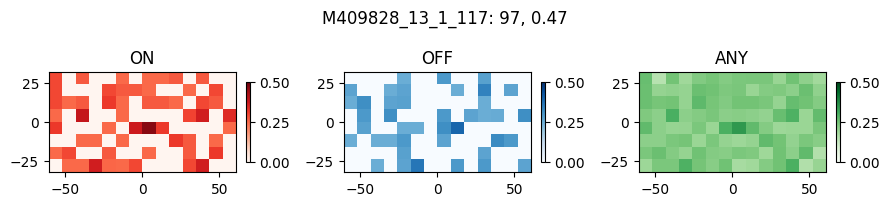

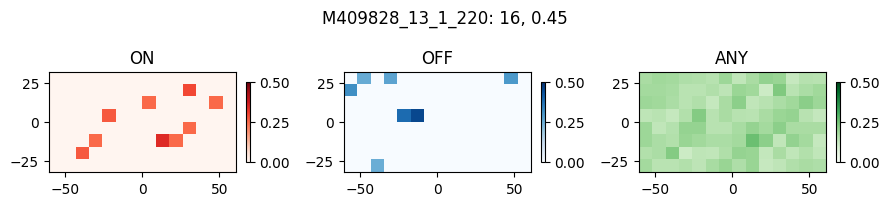

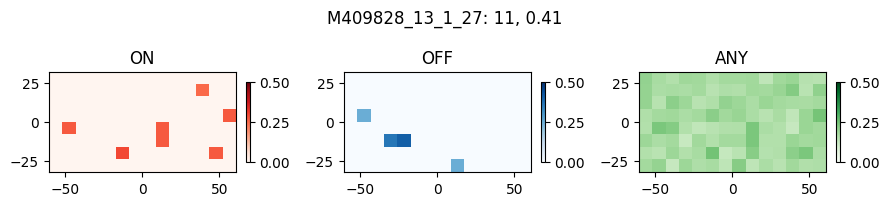

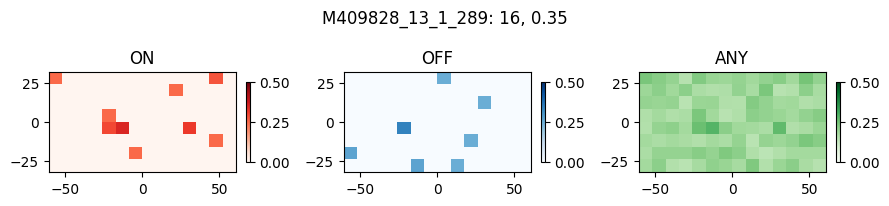

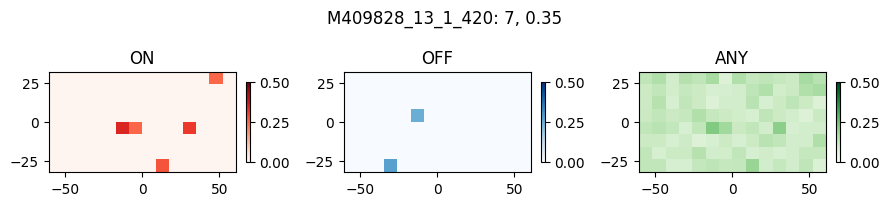

In [40]:
responsive_rois = []
valid_rois = np.where(session.is_roi_valid(plane))[0]

FRAC_SIG_TRIALS_THRESH = 0.25 # ~11 in ~44 total

for roi in valid_rois:
    roi_sweep_responses = lsn.sweep_responses[:, roi]
    roi_sig_sweep_responses = roi_sweep_responses > roi_boot_95[roi]
    frac_sig_trials = lsn.design_matrix.astype(int).dot(roi_sig_sweep_responses) / n_pixel_trials
    is_pixel_sig = frac_sig_trials >= FRAC_SIG_TRIALS_THRESH
    n_sig_pixels = np.count_nonzero(is_pixel_sig)

    if n_sig_pixels > 0:
        responsive_rois.append({
            "roi": roi,
            "n_sig_pixels": n_sig_pixels,
            "max_frac_responsive_trials": np.max(frac_sig_trials),
            "rf_on": np.where(is_pixel_sig, frac_sig_trials, 0)[:lsn.n_pixels].reshape(lsn.image_shape),
            "rf_off": np.where(is_pixel_sig, frac_sig_trials, 0)[lsn.n_pixels:].reshape(lsn.image_shape),
            "rf_any": (design_matrix_ignore_on_off.astype(int).dot(roi_sig_sweep_responses) / n_pixel_trials_ignore_on_off).reshape(lsn.image_shape)
        })

print(f"Responsive rate: {len(responsive_rois)} / {len(valid_rois)} ({len(responsive_rois)/len(valid_rois)*100:.1f}%)")

responsive_rois.sort(key=itemgetter("max_frac_responsive_trials"), reverse=True)

imshow_extent = [lsn.azimuths[0], lsn.azimuths[-1], lsn.altitudes[0], lsn.altitudes[-1]]

for data in responsive_rois[:5]:
    fig, axs = plt.subplots(figsize=(9, 2), ncols=3)
    # im = axs[0].imshow(frac_sig_trials[:lsn.n_pixels].reshape(lsn.image_shape), cmap="Reds", vmin=0, vmax=0.5, origin="lower", extent=imshow_extent)
    im = axs[0].imshow(data["rf_on"], cmap="Reds", vmin=0, vmax=0.5, origin="lower", extent=imshow_extent)
    # y, x = np.median(np.where(data["rf_on"]), axis=1)
    # axs[0].scatter(x, y, color="blue")
    # y, x = np.mean(np.where(data["rf_on"]), axis=1)
    # y, x = np.average(np.where(data["rf_on"]), axis=1, weights=data["rf_on"][np.where(data["rf_on"])])
    # axs[0].scatter(x, y, color="purple")
    fig.colorbar(im, fraction=0.02)
    axs[0].set_title("ON")

    # im = axs[1].imshow(frac_sig_trials[lsn.n_pixels:].reshape(lsn.image_shape), cmap="Blues", vmin=0, vmax=0.5, origin="lower", extent=imshow_extent)
    im = axs[1].imshow(data["rf_off"], cmap="Blues", vmin=0, vmax=0.5, origin="lower", extent=imshow_extent)
    fig.colorbar(im, fraction=0.02)
    axs[1].set_title("OFF")

    im = axs[2].imshow(data["rf_any"], cmap="Greens", vmin=0, vmax=0.5, origin="lower", extent=imshow_extent)
    fig.colorbar(im, fraction=0.02)
    axs[2].set_title("ANY")

    # im = axs[2].imshow(data["rf_on"] - data["rf_off"], cmap="RdBu_r", vmin=-0.5, vmax=0.5, origin="lower", extent=imshow_extent)
    # im = axs[2].imshow(np.where(data["rf_on"] > data["rf_off"], data["rf_on"], -data["rf_off"]), cmap="RdBu_r", vmin=-0.5, vmax=0.5, origin="lower", extent=imshow_extent)
    # fig.colorbar(im, fraction=0.02)
    # axs[2].set_title("ON & OFF")

    fig.suptitle(f"{session.get_session_id()}_{plane}_{data['roi']}: {data['n_sig_pixels']}, {data['max_frac_responsive_trials']:.2f}")
    fig.tight_layout()

    # break

In [73]:
def rf_center_to_alt_azi(alt_ctr, azi_ctr):
    alt = alt_ctr * (lsn.altitudes[-1] - lsn.altitudes[0]) / len(lsn.altitudes) + lsn.altitudes[0]
    azi = azi_ctr * (lsn.azimuths[-1] - lsn.azimuths[0]) / len(lsn.azimuths) + lsn.azimuths[0]
    return alt, azi

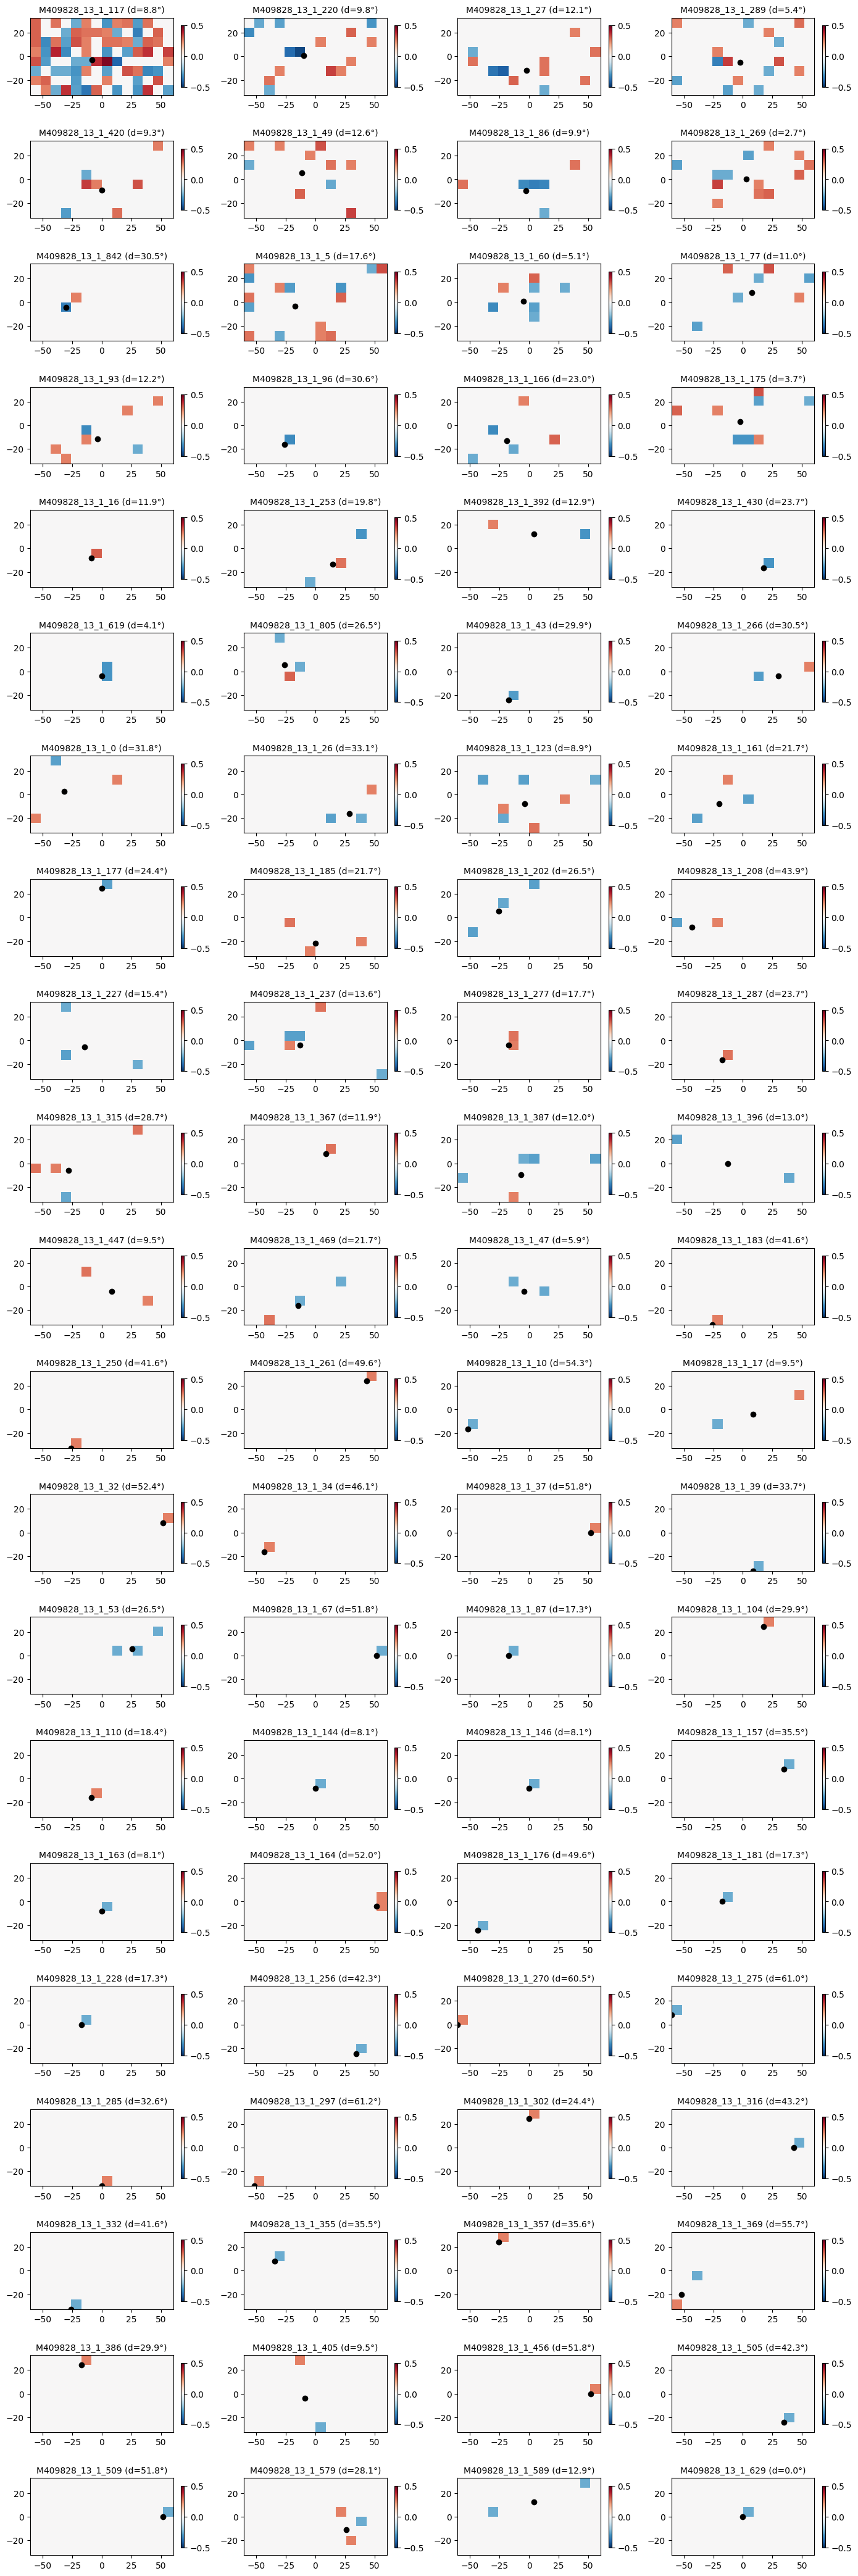

In [77]:
ncols = 4
# nrows = 1
nrows = int(np.ceil(len(responsive_rois) / ncols))
fig, axs = plt.subplots(figsize=(ncols*3.5, nrows*2), nrows=nrows, ncols=ncols)
axs = axs.flatten()

for i, ax in enumerate(axs):
    if i < len(responsive_rois):
        data = responsive_rois[i]
        rf = np.where(data["rf_on"] > data["rf_off"], data["rf_on"], -data["rf_off"])
        im = ax.imshow(rf, cmap="RdBu_r", vmin=-0.5, vmax=0.5, origin="lower", extent=imshow_extent)
        fig.colorbar(im, fraction=0.02)

        # Plot the center
        alt, azi = rf_center_to_alt_azi(*np.mean(np.where(rf), axis=1))
        ax.scatter(azi, alt, s=36, color="black")
        rf_ctr_dist = np.sqrt(alt**2 + azi**2)

        # if i == 0: fig.colorbar(im, fraction=0.02)
        ax.set_title(f"{session.get_session_id()}_{plane}_{data['roi']} (d={rf_ctr_dist:.1f}°)", fontsize=10)
    else:
        ax.axis("off")

fig.tight_layout()

Look at some DG responses of the above ROIs

In [54]:
from allen_v1dd.stimulus_analysis import DriftingGratings
dgw = DriftingGratings(session, plane, dg_type="windowed", quick_load=True)
dgf = DriftingGratings(session, plane, dg_type="full", quick_load=True)

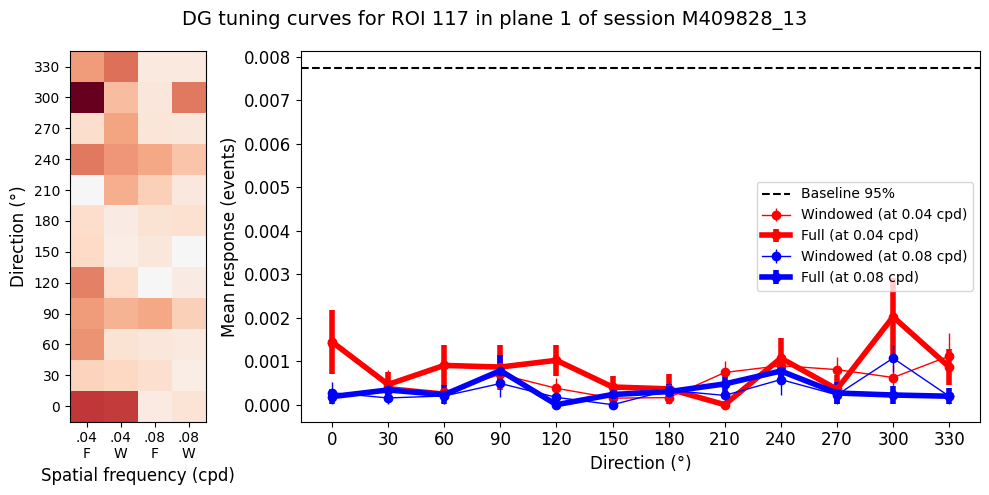

In [61]:
dgw.plot_roi_tuning_curves(117, dg_other=dgf, figsize=(10, 5))

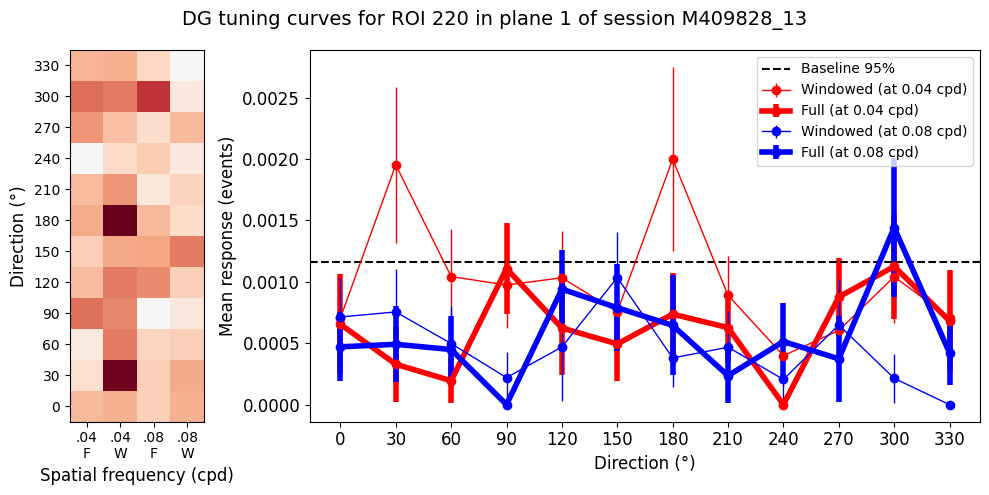

In [63]:
dgw.plot_roi_tuning_curves(220, dg_other=dgf, figsize=(10, 5))

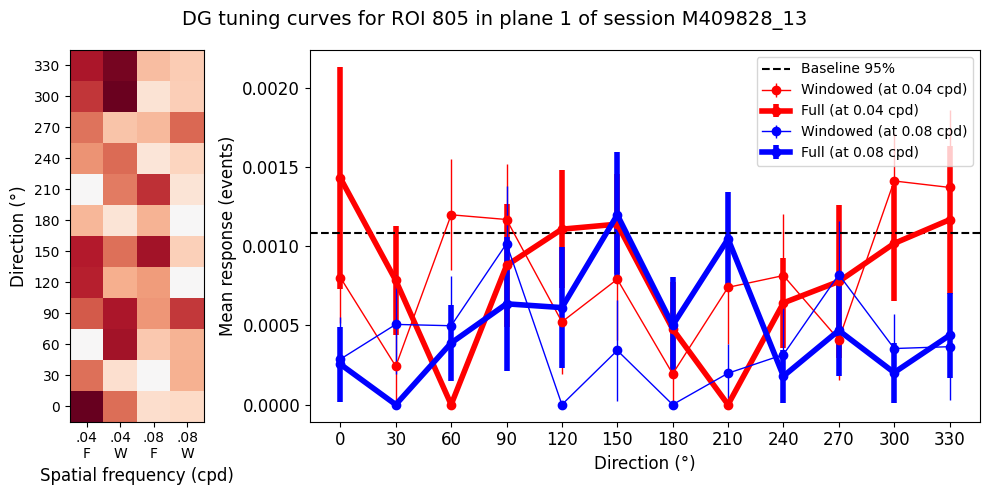

In [65]:
dgw.plot_roi_tuning_curves(805, dg_other=dgf, figsize=(10, 5))